In [1]:
from fastai.text import * 
from fastai.callbacks import *
from sklearn.model_selection import train_test_split
from pathlib import Path
import pickle as pkl

In [2]:
PATH = Path('.')
MODELS_PATH = PATH / 'models'
MODELS_PATH.mkdir(exist_ok=True)

In [3]:
import unicodedata
import pandas as pd
import re
import spacy

In [4]:
def normalize_title(title):
    s = re.sub(r'[^a-zA-Z0-9ñç%. ]', ' ', unicodedata.normalize('NFKD', title.lower()).encode('ascii', 'ignore').decode("utf-8"))
    s = re.sub(r'[\d]+ | [\d]+', " X", s)
    s = re.sub(r's |s$', ' ', s)
    s = re.sub(r' +', ' ', s)
    return re.sub(r'o |o$', 'a ', s).strip()
        

In [14]:
print(normalize_title('"Avon Alhambra,{} Piedra Pómez 342 322 e 54gr Y M123 Desodorante"'))
print(normalize_title("5 Fuentes De Pc A Reparar O Repuestos"))

avon alhambra piedra pomez X X e Xgr y m Xdesodorante
Xfuente de pc a reparar a repuesta


In [65]:
if not (PATH / 'train_prepro.csv').exists():
    df = pd.read_csv(PATH / 'train.csv')
    
    df['title'] = df.title.apply(normalize_title)
    df = df[~df.title.isna() & (df.title != 'nan') & (df.title != '')]

    df.to_csv(PATH / 'train_prepro.csv', index=False)

In [66]:
if not (PATH / 'data_lm_export.pkl').exists():
    data_lm = TextLMDataBunch.from_csv(
        PATH, 'train_prepro.csv', text_cols='title', label_cols='category', 
        valid_pct=0.05, max_vocab=100000, bs=64
    )


    data_lm.save('data_lm_export.pkl')
else:
    print('Loading databunch...')
    data_lm = load_data(PATH, 'data_lm_export.pkl')

In [2]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5, pretrained=False)

NameError: name 'language_model_learner' is not defined

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-05
Min loss divided by 10: 4.37E-04


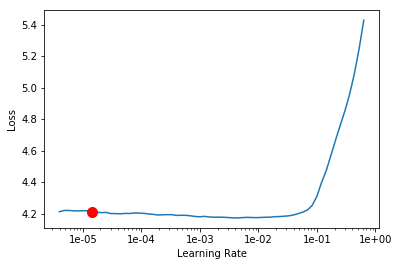

In [74]:
learn.lr_find()
learn.recorder.plot(skip_end=10, skip_start=20, suggestion=True)

In [1]:
learn.fit_one_cycle(
    10, 4e-3, callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy', name='lm'), EarlyStoppingCallback(learn, monitor='accuracy', min_delta=0.1, patience=3)]
)

NameError: name 'learn' is not defined

In [79]:
learn.save_encoder('lm_enc')

In [80]:
learn.save('lm')

In [75]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.148349,4.017953,0.336945,3:17:23


In [78]:
learn.fit_one_cycle(1, 1e-2/3)

epoch,train_loss,valid_loss,accuracy,time
0,4.062742,3.938420,0.345512,3:17:13


In [81]:
learn.fit_one_cycle(2, 1e-2/3)

epoch,train_loss,valid_loss,accuracy,time
0,4.181645,4.043610,0.333363,3:17:01
1,4.035264,3.885497,0.351714,3:17:43


In [82]:
learn.save_encoder('lm_enc2')
learn.save('lm2')

In [83]:
df_smp = pd.read_csv(PATH / 'train_prepro.csv')

In [93]:
data_lm.train_ds.vocab

In [4]:
if not (PATH / 'data_clas_export.pkl').exists():
    data_clas = TextClasDataBunch.from_csv(
        PATH, 
        'train_prepro.csv', 
        vocab=data_lm.train_ds.vocab, 
        bs=800, 
        text_cols='title', 
        label_cols='category',
        num_workers=1
    )
    
    data_clas.save('data_clas_export.pkl')
else:
    data_clas = load_data(PATH, 'data_clas_export.pkl')

In [97]:
data_clas.show_batch(rows=10)

text,target
xxbos kit rede branca x x xxmaj xx1 x x x xxmaj xx0 x x x xxmaj xx0 x x x xxmaj xx4 x x x xxmaj xx2 x x x xxmaj xx4 x x x xxmaj xx3 x,PROTECTION_NETS
xxbos bateria xxunk para acer aspire v5 serie v5 xxmaj xg v5 xxmaj xg v5 xxmaj xg e1 serie e1 xxmaj xp e1 xxmaj xp e1 xxmaj xg xxunk xxunk m,LAPTOP_BATTERIES
xxbos cable hdmi de alta velocidad xxunk cable hdmi x pie x pie compatible con xxmaj xk xxmaj xd xxmaj xp canal de retorna de au,AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS
xxbos bateria para dell xp x x precision xxunk xxmaj xrr xxmaj xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk x xxmaj xv xxmaj xwh x celda,LAPTOP_BATTERIES
xxbos memoria ram xxmaj xgb xxmaj xgbx2 para dell inspiron e1405 e1505 xxunk x b120 b130 xp gen x g2 m140 x xxmaj xm x,RAM_MEMORY_MODULES
xxbos kit rede branca x x xxmaj xx1 x x x xxmaj xx1 x x x xxmaj xx1 x x x xxmaj xx1 x,PROTECTION_NETS
xxbos 10 cil x x x x cil x x x x x cil y tca x x x xxmaj xllave x x,SCREWS
xxbos cana estructural rectangular de x x x x x x mm en barra de x mt de larga tuba hierra gramabi,PIPES_AND_TUBES
xxbos kit seguridad hikvision full hd lite dvr xxmaj xch x camara disca xxmaj xtb purple fuente derivador x cable cartel disuasiva,SURVEILLANCE_MONITORING_KITS
xxbos calca branca lycra bivik feminina elastana branca preta azul xxunk ou flare x aa x sarja tecida grossa veste bem,PANTS


In [105]:
data_clas.train_ds.x[6]

Text xxbos diesel zera plu m decant amostra xxmaj xml original frete grati

In [106]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, bptt=12, path=PATH)
learn.load_encoder('lm_enc2')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-01
Min loss divided by 10: 6.31E-02


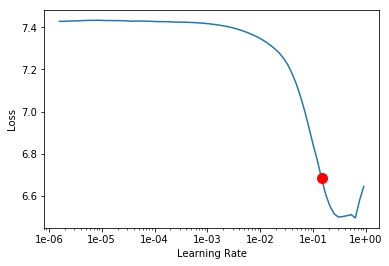

In [107]:
learn.lr_find()
learn.recorder.plot(skip_end=10, skip_start=15, suggestion=True)

In [108]:
learn.fit_one_cycle(1, 8e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.194767,0.886233,0.813788,38:38


In [109]:
learn.save('class_fit_head')

In [110]:
learn.freeze_to(-2)

In [111]:
learn.fit_one_cycle(1, slice(3e-3/(2.6**4), 3e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.898784,0.696986,0.849266,43:57


In [112]:
learn.save('class_fit_top2')

In [113]:
learn.unfreeze()

In [114]:
learn.fit_one_cycle(
    7, slice(3e-3/(2.6**4), 3e-3), moms=(0.8, 0.7), 
    callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy', name='class_fit_full')]
)

epoch,train_loss,valid_loss,accuracy,time
0,0.823603,0.660990,0.855746,1:21:06
1,0.806030,0.629765,0.861902,1:21:58
2,0.741846,0.603677,0.867034,1:02:37
3,0.704139,0.584585,0.871320,1:14:34
4,0.688411,0.566787,0.874653,1:24:44
5,0.644176,0.550823,0.877210,1:25:56
6,0.633675,0.548044,0.878074,1:23:38


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 2.51E-04


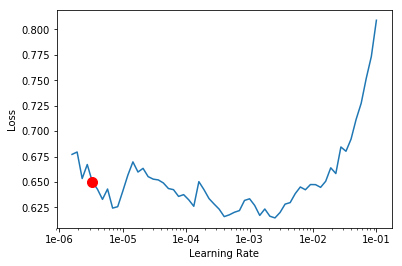

In [75]:
learn.lr_find()
learn.recorder.plot(skip_end=10, skip_start=15, suggestion=True)

In [116]:
learn.fit_one_cycle(1, 1e-4/2)

epoch,train_loss,valid_loss,accuracy,time
0,0.683283,0.547660,0.878459,1:19:43


In [117]:
learn.save('class_fit_top3')

In [118]:
learn.fit_one_cycle(1, 1e-2/3)

epoch,train_loss,valid_loss,accuracy,time
0,0.649676,0.565369,0.875279,1:23:05


In [5]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, bptt=12, path=PATH)
learn.load('class_fit_full_6')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (15999998 items)
x: TextList
xxbos tabaca pipa xxunk navy blend mac baren envia grati ver,xxbos tuerca antirroba chery face llanta de xxunk,xxbos lijadora y atornillador desarmada para reparar a repuesta,xxbos balcaa arara olimpica cromada mc x,xxbos conjunta oshkosh beba x mese
y: CategoryList
TOBACCO_PIPES,ANTI_THEFT_STUDS,SANDER_MACHINES,RECEPTION_DESKS,BABY_CLOTHING_SETS
Path: .;

Valid: LabelList (4000000 items)
x: TextList
xxbos fuente seasonic m12ii x watt,xxbos juega de cortina x pana linea cisne rosa cocina a ambiente,xxbos lixadeira telescopica teta parede xxmaj xw x xxunk xxmaj xv,xxbos mochila jansport superbreak nueva modela x lt envia,xxbos pack x titere de deda cuenta granja personaje animale
y: CategoryList
DESKTOP_COMPUTER_POWER_SUPPLIES,INDOOR_CURTAINS_AND_BLINDS,SANDER_MACHINES,BACKPACKS,PUPPETS
Path: .;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(1

In [132]:
from sklearn.metrics import balanced_accuracy_score
learn.model.cuda()
probs = learn.get_preds(ds_type=DatasetType.Valid)
pred_indices = torch.argmax(probs[0], dim=1)
preds_clas = [data_clas.classes[pred] for pred in pred_indices]

RuntimeError: [enforce fail at CPUAllocator.cpp:56] posix_memalign(&data, gAlignment, nbytes) == 0. 12 vs 0


In [ ]:
true = [data_clas.classes[i] for i in probs[1].detach().numpy()]

In [ ]:
balanced_accuracy_score(true, preds_clas)

In [130]:
learn.pred_batch()

RuntimeError: cuda runtime error (33) : invalid resource handle at /opt/conda/conda-bld/pytorch_1556653114079/work/aten/src/THC/generic/THCTensorMath.cu:35

In [85]:
df = pd.read_csv(PATH / 'test.csv')

In [86]:
df['title'] = df.title.apply(normalize_title)
df.pop('language');
df.pop('id');

In [136]:
df.head()

,title
0,kit maternidade bolsa mala baby bebe vinha men...
1,trocador de fralda fisher price feminina rosa ...
2,motor ventoinha fiat idea palia X X a X k
3,amortecedor mola batente d dir new civic X X k
4,cadeirinha de carra bebe princesa princes X a ...


In [27]:
learn.data.add_test(df, label=None)

In [87]:
learn.data.show_batch(ds_type=DatasetType.Test, rows=10)

text,target
xxbos kit maternidade bolsa mala baby bebe vinha menina xxunk,3D_GLASSES
xxbos trocador de fralda fisher price feminina rosa portatil,3D_GLASSES
xxbos motor ventoinha fiat idea palia x x a x k,3D_GLASSES
xxbos amortecedor mola batente d dir new civic x x k,3D_GLASSES
xxbos cadeirinha de carra bebe princesa princes x a x kg,3D_GLASSES
xxbos caba freia maa tra direita vw up cod xxmaj xxunk x j,3D_GLASSES
xxbos mini pc dell optiplex fx160 atom xxmaj xgb ram ssd xxmaj xgb wifi,3D_GLASSES
xxbos kit bi xenon lampada h4 xxmaj xk,3D_GLASSES
xxbos protetor pe botinha kickboxing karate taekwonda competicaa,3D_GLASSES
xxbos disca rigida externa western digital element xxmaj xtb usb3 x,3D_GLASSES


In [88]:
probs = learn.get_preds(ds_type=DatasetType.Test)
pred_indices = torch.argmax(probs[0], dim=1)
preds_clas = [data_clas.classes[pred] for pred in pred_indices]

In [89]:
for x in range(10, 20):
    print(learn.data.test_ds[x], preds_clas[x])

(Text xxbos picadora de carne fineschi legitima x, EmptyLabel ) MEAT_GRINDERS
(Text xxbos saida maternidade x manta xxmaj xxunk xxmaj xcalca brinde ref x, EmptyLabel ) BABY_CLOTHING_SETS
(Text xxbos joga vela ignicaa ngk mercede benz x x clc x kompressor, EmptyLabel ) SPARK_PLUGS
(Text xxbos modula de injecaa fox flex xxwrep 5 x aa, EmptyLabel ) ENGINE_CONTROL_MODULES
(Text xxbos set barreta automotor bremen x3 unid x x x xxmaj xcm, EmptyLabel ) CROWBARS
(Text xxbos miel organica x250gr sin tacc, EmptyLabel ) HONEY
(Text xxbos sax tenor coon xxmaj xm, EmptyLabel ) SAXOPHONES
(Text xxbos sapata seguranca vaqueta bidensidade com biqueira de pvc, EmptyLabel ) SAFETY_FOOTWEAR
(Text xxbos 200 adaptador para cartaa de memoria micra sd frete grati, EmptyLabel ) MEMORY_CARD_READERS
(Text xxbos bandeja giradisca xxunk xxunk, EmptyLabel ) TURNTABLES


In [90]:
df = pd.read_csv(PATH / 'test.csv')
df.pop('language');
df.pop('title');
df['category'] = preds_clas

In [91]:
df.to_csv('submission.csv', index=False)

In [31]:
learn.data

TextClasDataBunch;

Train: LabelList (15999998 items)
x: TextList
xxbos tabaca pipa xxunk navy blend mac baren envia grati ver,xxbos tuerca antirroba chery face llanta de xxunk,xxbos lijadora y atornillador desarmada para reparar a repuesta,xxbos balcaa arara olimpica cromada mc x,xxbos conjunta oshkosh beba x mese
y: CategoryList
TOBACCO_PIPES,ANTI_THEFT_STUDS,SANDER_MACHINES,RECEPTION_DESKS,BABY_CLOTHING_SETS
Path: .;

Valid: LabelList (4000000 items)
x: TextList
xxbos fuente seasonic m12ii x watt,xxbos juega de cortina x pana linea cisne rosa cocina a ambiente,xxbos lixadeira telescopica teta parede xxmaj xw x xxunk xxmaj xv,xxbos mochila jansport superbreak nueva modela x lt envia,xxbos pack x titere de deda cuenta granja personaje animale
y: CategoryList
DESKTOP_COMPUTER_POWER_SUPPLIES,INDOOR_CURTAINS_AND_BLINDS,SANDER_MACHINES,BACKPACKS,PUPPETS
Path: .;

Test: LabelList (246955 items)
x: TextList
xxbos kit maternidade bolsa mala baby bebe vinha menina xxunk,xxbos trocador de fral

In [49]:
df.groupby('category').count().sort_values('id').to_csv('count.csv', index=True)

In [55]:
data_clas.train_ds.add(data_clas.valid_ds)

TextList (19999998 items)
xxbos tabaca pipa xxunk navy blend mac baren envia grati ver,xxbos tuerca antirroba chery face llanta de xxunk,xxbos lijadora y atornillador desarmada para reparar a repuesta,xxbos balcaa arara olimpica cromada mc x,xxbos conjunta oshkosh beba x mese
Path: .

In [69]:
learn.data.train_ds.y

CategoryList (15999998 items)
TOBACCO_PIPES,ANTI_THEFT_STUDS,SANDER_MACHINES,RECEPTION_DESKS,BABY_CLOTHING_SETS
Path: .

In [72]:
data_clas.train_ds.y.add(data_clas.valid_ds.y)

CategoryList (19999998 items)
TOBACCO_PIPES,ANTI_THEFT_STUDS,SANDER_MACHINES,RECEPTION_DESKS,BABY_CLOTHING_SETS
Path: .

CategoryList (19999998 items)
TOBACCO_PIPES,ANTI_THEFT_STUDS,SANDER_MACHINES,RECEPTION_DESKS,BABY_CLOTHING_SETS
Path: .

In [84]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(3e-6/(2.6**4), 3e-6), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.690672,0.549407,0.877734,4:59:38


In [8]:
#interp = TextClassificationInterpretation.from_learner(learn) 
val_batch_iter = iter(learn.data.valid_dl)
for n in range(0, 30):
    batch = next(val_batch_iter)
    preds = learn.pred_batch(batch=batch)
    print(preds.shape)
    break

torch.Size([64, 1588])


In [ ]:
interp.show_top_losses()

In [17]:
learn.data.add_test(learn.data.valid_ds.x[0:30], learn.data.valid_ds.y[0:30])

TypeError: unhashable type: 'numpy.ndarray'